# CNTK 105: Basic autoencoder with MNIST data

We assume that you have successfully downloaded the MNIST data by completing CNTK 103 Part A.


## Introduction

In this tutorial we introduce you to the basics of [Autoencoders](https://en.wikipedia.org/wiki/Autoencoder). An autoencoder is an artificial neural network used for unsupervised learning of efficient encodings. In other words, they are used for lossy data-specific compression that are learnt automatically instead of human engineered features. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. 

The autoencoders are very specific to the data-set on hand and are different from standard codecs such a JPEG, MPEG standard based encodings. Once the information is encoded and decoded back to original dimensions some amount of information is lost in the process. Given these encodings are specific to data, autoencoders are not used for compression. However, there are two areas where autoencoders have been found very effective: (1) denoising and (2) dimensionality reduction.

Autoencoders have attracted attention since they have long been thought to be a potential approach for unsupervised learning. Truly unsupervised approaches involve learning useful representations without the need for labels. Autoencoders fall under self-supervised learning, a specific instance of supervised learning where the targets are generated from the input data. 

**Problem** 
The MNIST data comprises of hand-written digits with little background noise.

<img src="http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200>

In this tutorial, we will reuse the [MNIST hand-written digits data](https://en.wikipedia.org/wiki/MNIST_database) to illustrate encoding the images and decoding (restoring) them using feed-forward networks. 

**Goal**:
Our goal is to train an autoencoder that compresses MNIST digits image to a smaller dimension and then restore the image. We will visualize the original and the restored images. We illustrate feed forward network based both simple autoencoder and deep autoencoder. More advanced autoencoders will be covered in 200 series tutorials.


In [1]:
# Import the relevant components
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

#Import CNTK related components
import cntk as C
from cntk.blocks import default_options, Input        # building blocks
from cntk.device import set_default_device, gpu, cpu  
from cntk.layers import Dense
from cntk import Trainer, StreamConfiguration
from cntk.io import StreamDef, StreamDefs, INFINITELY_REPEAT, FULL_DATA_SWEEP
from cntk.io import MinibatchSource, CTFDeserializer
from cntk.initializer import glorot_uniform
from cntk.learner import adam_sgd, UnitType
from cntk.learner import learning_rate_schedule, momentum_as_time_constant_schedule
from cntk.utils import *

%matplotlib inline

Set the device to cpu / gpu

In [2]:
# For gpu provide the gpu Id say gpu(0)
set_default_device(gpu(0))

### Select the notebook run mode

There are two run modes:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

In [3]:
isFast = True

## Data reading

In this section, we will read the data generated in CNTK 103 Part A.

The data is in the following format:

    |labels 0 0 0 0 0 0 0 1 0 0 |features 0 0 0 0 ... 784 (integers each representing a pixel)
    
 In this tutorial we are going to use the image pixels corresponding the integer stream named "features". We define a `create_reader` function to read the training and test data. The labels are [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). We ignore them in this tutorial. 

We also check if the training and test data file has been downloaded and available for reading by the `create_reader` function. In this tutorial we are using the MNIST data you have downloaded using CNTK_103A_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels.

In [4]:
def create_reader(path, is_training, input_dim, num_label_classes):
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        labels_viz    = StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features  = StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize=is_training, epoch_size = INFINITELY_REPEAT if is_training else FULL_DATA_SWEEP)

In [5]:
# Ensure the training data is generated and available for this tutorial
train_file = "data/MNIST/Train-28x28_cntk_text.txt"

if not os.path.isfile(train_file):
    print("Training data from file {0} found.".format(train_file))
    print("Please generate the data by completing CNTK 103 Part A")

test_file = "data/MNIST/Test-28x28_cntk_text.txt"

if not os.path.isfile(test_file):
    print("Test data from file {0} found.".format(path))
    print("Please generate the data by completing CNTK 103 Part A")

<a id='#Model Creation'></a>
## Model Creation

We start with a simple single fully-connected feedforward network as encoder and as decoder (as shown in the figure below):

<img src="http://cntk.ai/jup/SimpleAEfig.jpg",width=200, height=200>

The input data are a set of hand written digits images each 28 x28 pixels. In this tutorial, we will consider each image as a linear array of 784 pixel values as input. Since the goal of the autoencoder is to compress the data and reconstruct the original image, the output dimension is same as the input dimension. We will compress the input to mere 32 values (referred to as the `encoding_dim`). Additionally, since the maximum input value is 255, we normalize the input between 0 and 1. 

In [6]:
input_dim = 784
encoding_dim = 32
output_dim = input_dim


def create_model(features):
    with default_options(init = glorot_uniform()):
        scaled = C.element_times(C.constant(1.0/255.0), features)
        encode = Dense(encoding_dim, activation = C.relu)(scaled)
        decode = Dense(input_dim, activation = C.sigmoid)(encode)

    return decode

## Setup the network for training and testing

In previous tutorials, we have defined each of the training and testing phases separately. In this tutorial, we combine the two componets in one place such that this template could be used as a recipe for your usage.  

The `train_and_test` function performs two major tasks:
- Train the model
- Evaluate the accuracy of the model on test data

For training:

> The function takes a reader (`reader_train`), a model function (`model_func`) and the target (a.k.a `label`) as input. In this tutorial, we show how to create and pass your **own** loss function. We normalize the `label` function to emit value between 0 and 1 for us to compute the label error using `C.classification_error` function.

> We use Adam optimizer in this tutorial from a range of [learners](https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner)(optimizers) available in the toolkit.  

For testing:

> The function additionally takes a reader  (`reader_test`) and evaluates the predicted pixel values made by the model against reference data, in this case the original pixel values for each image.


In [7]:
def train_and_test(reader_train, reader_test, model_error, model_func):
    
    ###############################################
    # Training the model
    ###############################################
    
    # Instantiate the input and the label variables
    input = Input(input_dim)
    label = Input(input_dim)
    
    # Create the model function
    model = model_func(input)
    
    # The labels for this network is same as the input MNIST image.
    # Note: Inside the model we are scaling the input to 0-1 range
    # Hence we rescale the label to the same range
    # We show how one can use their custom loss function
    # loss = -(y* log(p)+ (1-y) * log(1-p)) where p = model output and y = target
    # We have normalized the input between 0-1. Hence we scale the target to same range
    
    target = label/255 
    loss = -(target * C.log(model)+ (1- target) * C.log(1-model))
    label_error  = C.classification_error(model, target)
    
    # training config
    epoch_size = 30000        # 30000 samples is half the dataset size 
    minibatch_size = 64
    num_sweeps_to_train_with = 5 if isFast else 100
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
 
    
    # Instantiate the trainer object to drive the model training
    lr_per_sample = [0.00003]
    lr_schedule = learning_rate_schedule(lr_per_sample, UnitType.sample, epoch_size)
    
    # Momentum
    momentum_as_time_constant = momentum_as_time_constant_schedule(700)
    
    # We use a variant of the Adam optimizer which is known to work well on this dataset
    # Feel free to try other optimizers from 
    # https://www.cntk.ai/pythondocs/cntk.learner.html#module-cntk.learner
    learner = adam_sgd(model.parameters,
                       lr=lr_schedule, momentum=momentum_as_time_constant,
                       low_memory=True,
                       gradient_clipping_threshold_per_sample=15, 
                       gradient_clipping_with_truncation=True)

    # Instantiate the trainer
    trainer = Trainer(model, loss, label_error, learner)
    
    # Map the data streams to the input and labels.
    # Note: for autoencoders input == label
    input_map = {
        input  : reader_train.streams.features,
        label  : reader_train.streams.features
    }
    
    
    pp = ProgressPrinter(0)
    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
        
        # Run the trainer on and perform model training
        trainer.train_minibatch(data)  
        pp.update_with_trainer(trainer, with_metric=True)
        
    model_error.append(pp.avg_metric_since_start()*100)
    print("Average training error: {0:0.2f}%".format(pp.avg_metric_since_start()*100))
        
    ###############################################
    # Testing the model
    ###############################################
        
    # Test data for trained model
    test_minibatch_size = 32
    num_samples = 10000
    num_minibatches_to_test = num_samples / test_minibatch_size
    test_result = 0.0
    
    # Test error metric calculation
    metric_numer    = 0
    metric_denom    = 0

    test_input_map = {
        input  : reader_test.streams.features,
        label  : reader_test.streams.features
    }

    for i in range(0, int(num_minibatches_to_test)):
        data = reader_test.next_minibatch(test_minibatch_size,
                                       input_map = test_input_map)

        # Specify the mapping of input variables in the model to actual
        # minibatch data to be tested with
        eval_error = trainer.test_minibatch(data)
        
        # minibatch data to be trained with
        metric_numer += np.abs(eval_error * test_minibatch_size)
        metric_denom += test_minibatch_size

    # Average of evaluation errors of all test minibatches
    test_error = (metric_numer*100.0) / (metric_denom) 
    model_error.append(test_error)
    print("Average test error: {0:0.2f}%".format(test_error))
    
    return model


Let us train the simple autoencoder. We create a training and a test reader

In [8]:
def do_train():
    num_label_classes = 10
    reader_train = create_reader(train_file, True, input_dim, num_label_classes)
    reader_test = create_reader(test_file, False, input_dim, num_label_classes)
    z = train_and_test(reader_train, reader_test, simple_ae_error, model_func = create_model )

    return z

simple_ae_error = []
model = do_train()

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
      544        544      0.947      0.947            64
      544        544      0.931      0.923           192
      543        543      0.921      0.913           448
      542        541      0.924      0.927           960
      537        532      0.924      0.924          1984
      493        451      0.821      0.721          4032
      383        275      0.639       0.46          8128
      303        223      0.524      0.409         16320
      251        199      0.396      0.268         32704
      209        168      0.281      0.166         65440
      174        139      0.194      0.106        130944
      144        113      0.125     0.0554        261952
Average training error: 11.32%
Average test error: 3.09%


### Visualize the simple autoencoder results

In [9]:
# Read some data to run the eval
num_label_classes = 10
reader_eval = create_reader(test_file, False, input_dim, num_label_classes)

eval_minibatch_size = 50
eval_input_map = { input  : reader_eval.streams.features }    
    
eval_data = reader_eval.next_minibatch(eval_minibatch_size,
                                  input_map = eval_input_map)

img_data = eval_data[input].value

#Select a random image
idx = np.random.randint(0, eval_minibatch_size-1, size=1)[0]

orig_image = img_data[idx,:,:]
decoded_image = model.eval(orig_image)*255

# Print image statistics
def print_image_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img),
                                                                              np.median(img),
                                                                              np.mean(img),
                                                                              np.min(img))) 
    
# Print original image
print_image_stats(orig_image, "Original image statistics:")

# Print decoded image
print_image_stats(decoded_image, "Decoded image statistics:")


Original image statistics:
Max: 255.00, Median: 0.00, Mean: 31.33, Min: 0.00
Decoded image statistics:
Max: 252.97, Median: 4.82, Mean: 50.44, Min: 0.00


Lets plot the original and the decoded image. They should look visually similar.

In [10]:
# Define a helper function to plot a pair of images
def plot_image_pair(img1, text1, img2, text2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

    axes[0].imshow(img1, cmap="gray_r")
    axes[0].set_title(text1)
    axes[0].axis("off")

    axes[1].imshow(img2, cmap="gray_r")
    axes[1].set_title(text2)
    axes[1].axis("off")

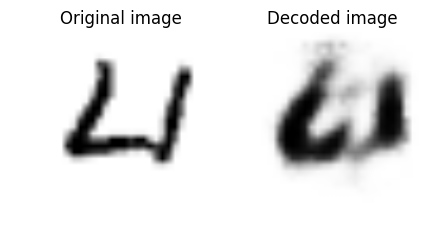

In [11]:
# Plot the original and the decoded image
img1 = orig_image.reshape(28,28)
text1 = 'Original image'

img2 = decoded_image.reshape(28,28)
text2 = 'Decoded image'

plot_image_pair(img1, text1, img2, text2)

## Deep Auto encoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of dense layers. Let us create a deep autoencoder.

<img src="http://cntk.ai/jup/DeepAEfig.jpg",width=500, height=300>

The encoding dimensions are 128, 64 and 32 while the decoding dimensions are symmetrically opposite 64, 128 and 784. If we train this deep encoder for larger number iterations by turning the `isFast` flag to be `False`, we get a lower error and the reconstructed images are also marginally better. 

In [12]:
input_dim = 784
encoding_dims = [128,64,32]
decoding_dims = [64,128]

encoded_model = {"encode":None} 

def create_deep_model(features):
    with default_options(init = glorot_uniform()):
        encode = C.element_times(C.constant(1.0/255.0), features)

        for encoding_dim in encoding_dims:
            encode = Dense(encoding_dim, activation = C.relu)(encode)

        encoded_model['encode'] = encode
        
        decode = encode
        for decoding_dim in decoding_dims:
            decode = Dense(decoding_dim, activation = C.relu)(decode)

        decode = Dense(input_dim, activation = C.sigmoid)(decode)
        return decode  

In [13]:
def do_deep_train():
    num_label_classes = 10
    reader_train = create_reader(train_file, True, input_dim, num_label_classes)
    reader_test = create_reader(test_file, False, input_dim, num_label_classes)

    z = train_and_test(reader_train, reader_test, deep_ae_error, model_func = create_deep_model )
    return z

deep_ae_error = []
model = do_deep_train()

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
      543        543       0.71       0.71            64
      543        543      0.749      0.768           192
      543        543      0.757      0.763           448
      542        541      0.742      0.729           960
      528        514      0.642      0.547          1984
      411        299      0.567      0.494          4032
      313        217      0.519      0.473          8128
      259        204      0.458      0.397         16320
      217        176      0.354      0.251         32704
      179        141      0.253      0.152         65440
      148        116       0.17     0.0867        130944
      124       99.3      0.111     0.0528        261952
Average training error: 10.23%
Average test error: 3.37%


### Visualize the deep autoencoder results

In [14]:
# Run the same image as the simple autoencoder through the deep encoder
orig_image = img_data[idx,:,:]
decoded_image = model.eval(orig_image)*255

# Print image statistics
def print_image_stats(img, text):
    print(text)
    print("Max: {0:.2f}, Median: {1:.2f}, Mean: {2:.2f}, Min: {3:.2f}".format(np.max(img),
                                                                              np.median(img),
                                                                              np.mean(img),
                                                                              np.min(img))) 
    
# Print original image
print_image_stats(orig_image, "Original image statistics:")

# Print decoded image
print_image_stats(decoded_image, "Decoded image statistics:")


Original image statistics:
Max: 255.00, Median: 0.00, Mean: 31.33, Min: 0.00
Decoded image statistics:
Max: 237.07, Median: 1.57, Mean: 28.78, Min: 0.00


Let us plot the original and the decoded image with the deep autoencoder. They should look visually similar.

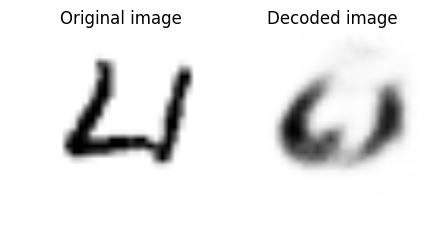

In [15]:
# Plot the original and the decoded image
img1 = orig_image.reshape(28,28)
text1 = 'Original image'

img2 = decoded_image.reshape(28,28)
text2 = 'Decoded image'

plot_image_pair(img1, text1, img2, text2)

## Dimensionality reduction using autoencoders

In this section we will explore an application of a utoencoders to reduce dimensionality of MNIST data. For visualizing high dimension data in 2D, [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is probably one of the best methods. However, it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to encode data into a low-dimensional space (e.g. 32 dimensional) using a autoencoder first, followed by using t-SNE for mapping the compressed data to a 2D plane. 

We will show how we can retrieve and encoded (compressed) data using our deep autoencoder. First we need to read some image data along with their labels. We will then use the labels to show similarity between original images as well as the corresponding encoded image stream.

In [16]:
# Read some data to run get the image data and the corresponding labels
num_label_classes = 10
reader_viz = create_reader(test_file, False, input_dim, num_label_classes)

image = Input(input_dim)
image_label = Input(num_label_classes)

viz_minibatch_size = 50

viz_input_map = { 
    image  : reader_viz.streams.features, 
    image_label  : reader_viz.streams.labels_viz 
}    
    
viz_data = reader_eval.next_minibatch(viz_minibatch_size,
                                  input_map = viz_input_map)

img_data   = viz_data[image].value
imglabel_raw = viz_data[image_label].value



In [17]:
# Map the image labels into indices in minibatch array
img_labels = [np.argmax(imglabel_raw[i,:,:]) for i in range(0, imglabel_raw.shape[0])]
label_dict = dict()

for img_idx, img_label, in enumerate(img_labels):
    if img_label in label_dict:
        label_dict[img_label].append(img_idx)
    else:
        label_dict[img_label] = [img_idx]
        
print(label_dict)


{0: [5, 19, 21], 1: [7, 24, 39, 44, 46], 2: [22, 27, 32], 3: [1, 13, 18, 26, 37, 40, 43], 4: [6, 15, 17, 35, 45], 5: [2, 3, 9], 6: [0, 4, 16, 31, 38, 41, 48], 7: [10, 14, 20, 25, 29, 30, 33, 36, 47], 8: [11, 34], 9: [8, 12, 23, 28, 42, 49]}


We will compute cosine similarity between two images from Scikit package.

In [18]:
from scipy import spatial

def image_pair_cosine_distance(img1, img2):
    
    if not len(img1) == len(img2):
        print("Two images need to be of same dimension")
        return None
    
    return 1 - spatial.distance.cosine(img1, img2)

Distance between two original image: 0.174
Distance between two decoded image: 0.317


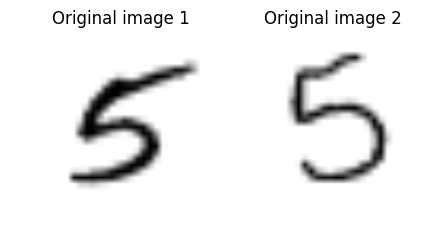

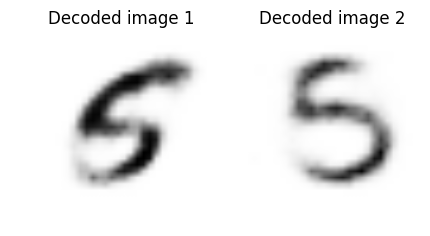

In [19]:
# Let s compute the distance between two images of the same number
digit_of_interest = 5

digit_index_list = label_dict[digit_of_interest]

if len(digit_index_list) < 2:
    print("Need at least two images to compare")
else:
    imgA = img_data[digit_index_list[0],:,:][0] 
    imgB = img_data[digit_index_list[1],:,:][0]
    
    # Print distance between original image
    imgA_B_dist = image_pair_cosine_distance(imgA, imgB)
    print("Distance between two original image: {0:.3f}".format(imgA_B_dist))
    
    # Plot the two images
    img1 = imgA.reshape(28,28)
    text1 = 'Original image 1'

    img2 = imgB.reshape(28,28)
    text2 = 'Original image 2'

    plot_image_pair(img1, text1, img2, text2)
    
    # Decode the encoded stream 
    imgA_decoded =  model.eval([imgA])
    imgB_decoded =  model.eval([imgB])       
    imgA_B_decoded_dist = image_pair_cosine_distance(imgA_decoded, imgB_decoded)

    #Print distance between original image
    print("Distance between two decoded image: {0:.3f}".format(imgA_B_decoded_dist))
    
    #Plot the two images
    # Plot the original and the decoded image
    img1 = imgA_decoded.reshape(28,28)
    text1 = 'Decoded image 1'

    img2 = imgB_decoded.reshape(28,28)
    text2 = 'Decoded image 2'

    plot_image_pair(img1, text1, img2, text2)


Note: The cosine distance between the original images is close to the distance between the corresponding decoded images. 

Let us now see how to get the output of the encoded input image. This should have the dimension of the choke point in the network show in the figure with the box labeled `E`.

In [20]:
imgA = img_data[digit_index_list[0],:,:][0] 
imgA_encoded =  encoded_model['encode'].eval([imgA])

print("Length of the original image is {0:3d} and the encoded image is {1:3d}".format(len(imgA), 
                                                                                      len(imgA_encoded[0][0])))
print("\nThe encoded image: ")
print(imgA_encoded[0][0])

Length of the original image is 784 and the encoded image is  32

The encoded image: 
[  7.9770298    0.           5.92800856   4.17102051  13.38818932
   5.84852171   9.4152689    0.           3.99066949  11.34112549
   4.02780628   0.          12.10341644   0.55060261   6.54121685   0.
   8.46840477  14.05648804   0.          18.34903526   2.60724688
  12.31196022   0.          14.88352108  18.52850723  11.5609436
  14.1935873   19.6335144    7.56256628  14.74243069  16.73602104
   9.52261734]


Let us compare the distance between different digits.

Distance between two original image: 0.376
Distance between two decoded image: 0.455


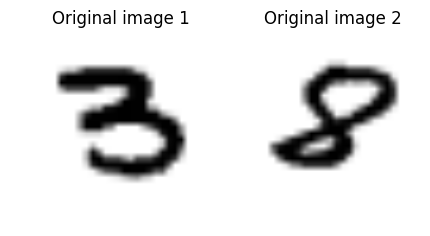

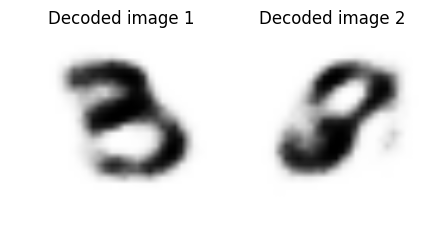

In [21]:
# Let s compute the distance between two similar digit say 7 and 9
digitA = 3
digitB = 8

digitA_index = label_dict[digitA]
digitB_index = label_dict[digitB]

imgA = img_data[digitA_index[0],:,:][0] 
imgB = img_data[digitB_index[0],:,:][0]

    
# Print distance between original image
imgA_B_dist = image_pair_cosine_distance(imgA, imgB)
print("Distance between two original image: {0:.3f}".format(imgA_B_dist))
    
# Plot the two images
img1 = imgA.reshape(28,28)
text1 = 'Original image 1'

img2 = imgB.reshape(28,28)
text2 = 'Original image 2'

plot_image_pair(img1, text1, img2, text2)
    
# Decode the encoded stream 
imgA_decoded =  model.eval([imgA])
imgB_decoded =  model.eval([imgB])       
imgA_B_decoded_dist = image_pair_cosine_distance(imgA_decoded, imgB_decoded)

#Print distance between original image
print("Distance between two decoded image: {0:.3f}".format(imgA_B_decoded_dist))
    

# Plot the original and the decoded image
img1 = imgA_decoded.reshape(28,28)
text1 = 'Decoded image 1'

img2 = imgB_decoded.reshape(28,28)
text2 = 'Decoded image 2'

plot_image_pair(img1, text1, img2, text2)

Print the results of the deep encoder test error for regression testing

In [22]:
# Simple autoencoder test error
print(simple_ae_error[1])

3.0876520251


In [23]:
# Deep autoencoder test error
print(deep_ae_error[1])

3.36810074603


## Suggested tasks

- Try different activation functions.
- Find which images are more similar to one another (a) using original image and (b) decoded image.
- Try using mean square error as the loss function. Does it improve the performance of the encoder in terms of reduced errors.
- Can you try different network structure to reduce the error further. Explain your observations.
- Can you use a different distance metric to compute similarity between the MNIST images.